# Binary Classification of Heart Disease using Personal Indicators

In [ ]:
pip install imblearn 


In [ ]:
pip install shap


In [ ]:
pip install tensorflow

In [119]:
import pandas as pd
import numpy as np
from statistics import mean
import collections
from collections import Counter


import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn import under_sampling
from imblearn.combine import SMOTEENN 
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import shap


import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_columns', None)

# Loading the data 

In [2]:
#DATA PREPROCESSING
raw_data = pd.read_csv("heart_2020_cleaned.csv")

In [3]:
raw_data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Check for any NA values, 
then look at the distrubuton of categorical data that needs encoding

In [134]:
raw_data.isna().sum()
#raw_data.shape

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [16]:
columns = data.columns
for column in columns:
    print(column,raw_data[column].unique())


HeartDisease ['No' 'Yes']
BMI [16.6  20.34 26.58 ... 62.42 51.46 46.56]
Smoking ['Yes' 'No']
AlcoholDrinking ['No' 'Yes']
Stroke ['No' 'Yes']
PhysicalHealth [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.]
MentalHealth [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
DiffWalking ['No' 'Yes']
Sex ['Female' 'Male']
AgeCategory ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
Race ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Diabetic ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
PhysicalActivity ['Yes' 'No']
GenHealth ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
SleepTime [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 14. 20. 11. 13.
 17. 24. 19. 21. 22. 23.]
Asthma ['Yes' 'No']
KidneyDisease ['No' 'Yes']
Skin

# Encoding catagorical columns to numerical

In [3]:
#genheath is ordinal so to save computational power with one-hot-encoding convert using dictonary
#(make sure numbers reflect correct order)

def convert_GenHealth(data):
    severity_dict = {"Poor": 4, "Fair":3,"Good":2,"Very good":1, "Excellent" :0}
    df = data.replace({"GenHealth":severity_dict})
    return df


def convert_ordinal(data, category):
    od_encoder = OrdinalEncoder()
    data[[category]] = od_encoder.fit_transform(data[[category]])
    return data

#Identify columns which are "yes", "No" and convert to 0, 1
def find_binary_col(dataset):
    columns = dataset.columns
    binary_headers = []
    for header in columns:
        title = dataset[header].value_counts().keys().tolist()
        if len(title) == 2:
            #print(header, title)
            binary_headers.append(header)
    return binary_headers


def binary_columns_convert(dataset, columns):
    dataset[columns] = dataset[columns].apply(LabelEncoder().fit_transform)
    return dataset
    


    def one_hot_encode(data, categorical_cols):
    for col in categorical_cols:
        col_ohe = pd.get_dummies(data[col], prefix=col)
        data = pd.concat((data, col_ohe), axis=1).drop(col, axis=1)
    return data



def convert_to_numeric(data):
    df_columns =data.columns
    for column in df_columns:
        data[column] =pd.to_numeric(data[column])
    return data


In [4]:
def preprocessing_steps(data):   
    
    #Convert ordnial data GenHealth and AgeCategory
    step1 = convert_GenHealth(data)
    step2 =convert_ordinal(step1, "AgeCategory" )
    
    
    #convert yes/no or binary answers to 0 /1 
    binary_headers= find_binary_col(step2)
    #print(binary_headers)
    step3 = binary_columns_convert(dataset=step2, columns=binary_headers)
    
    
    #one-hot-encode categorical data
    step4 = one_hot_encode(step3, categorical_cols= ["Diabetic","Race"])
    
    
    #make sure all values are integers 
    processed_data = convert_to_numeric(step4)
    return processed_data

In [5]:
processed_data =preprocessing_steps(raw_data)
processed_data.head()
#data = processed_data


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0,16.60,1,0,0,3.0,30.0,0,0,7.0,...,0,0,1,0,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12.0,...,1,0,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,9.0,...,0,0,1,0,0,0,0,0,0,1
3,0,24.21,0,0,0,0.0,0.0,0,0,11.0,...,1,0,0,0,0,0,0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4.0,...,1,0,0,0,0,0,0,0,0,1


# Exploritory Data Anaylsis

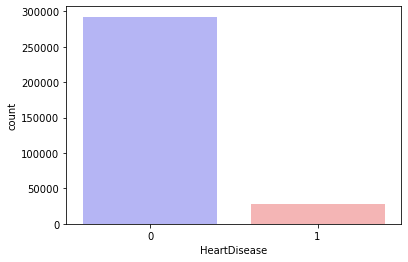

In [10]:
sns.countplot(x="HeartDisease", data=processed_data, palette="bwr")
plt.show()

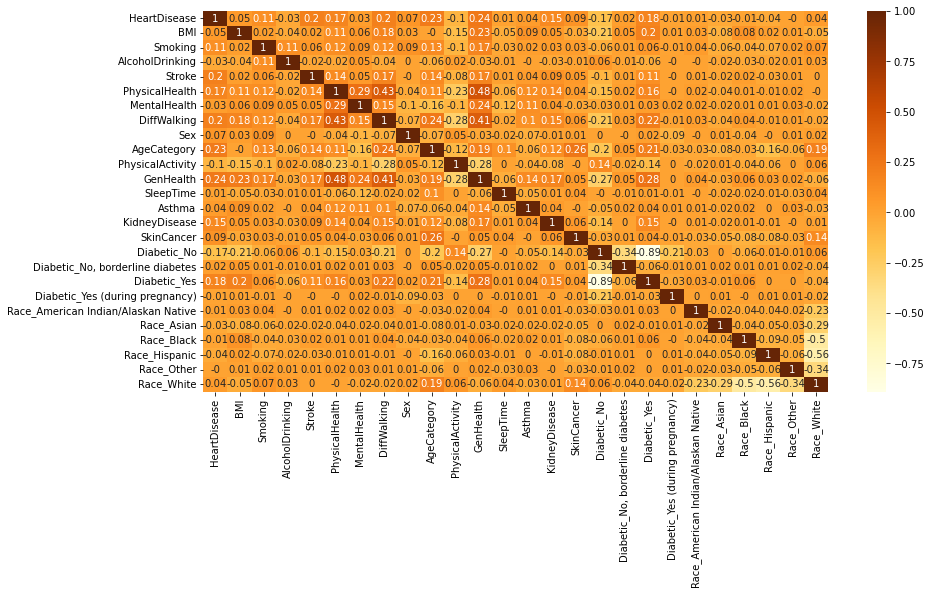

In [295]:
#understanding the data layout
def heat_map(data):
    correlation = data.corr().round(2)
    plt.figure(figsize = (14,7))
    sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')
    plt.show()
    
heat_map(processed_data)

In [150]:
averages = processed_data.groupby("HeartDisease").mean()
averages.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
HeartDisease,,,,,,,,,,,,,,,,,,,,,,,,,
0,28.224658,0.396246,0.070569,0.026263,2.956416,3.828778,0.117577,0.464572,6.259943,0.788135,1.327376,7.093416,0.129741,0.028466,0.084942,0.862227,0.020491,0.108901,0.008382,0.015936,0.026681,0.072532,0.088923,0.034341,0.761588
1,29.401592,0.585869,0.041683,0.160340,7.808242,4.641764,0.366346,0.589596,9.234318,0.638914,2.233917,7.136156,0.180214,0.126219,0.181931,0.640010,0.028824,0.327220,0.003945,0.019801,0.009718,0.063164,0.052716,0.032368,0.822234


Text(0.5, 1.0, 'Percentage of Cases of Heart Disease in each Race')

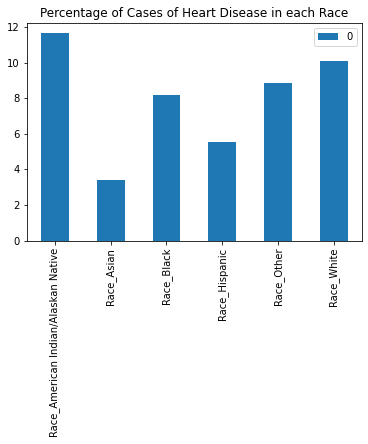

In [182]:
def count_plot_race():
    columns = ["Race_American Indian/Alaskan Native", "Race_Asian",
                             "Race_Black","Race_Hispanic","Race_Other", "Race_White"]
    list_of_dataframes = []
    for column in columns:
        new_data = processed_data.loc[processed_data[column] ==1]
        print(column)
        print(new_data["HeartDisease"].value_counts())
        #sns.countplot(x = "HeartDisease", data = new_data)
        #plt.title(column)
        #plt.show()


races = df.T
races.plot(kind="bar")
plt.title("Percentage of Cases of Heart Disease in each Race")

#count_plot_race()

<AxesSubplot:>

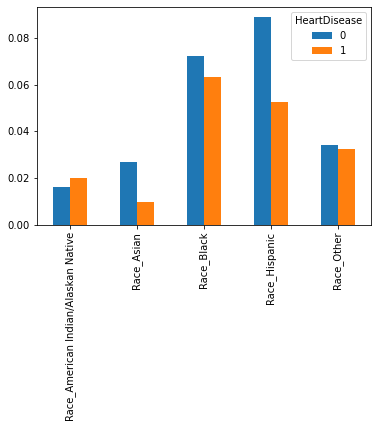

In [152]:
#remove white
race_averages = averages[["Race_American Indian/Alaskan Native", "Race_Asian",
                         "Race_Black","Race_Hispanic","Race_Other"]]
#race_averages.head()
races = race_averages.T
races.plot(kind="bar")

<function matplotlib.pyplot.show(close=None, block=None)>

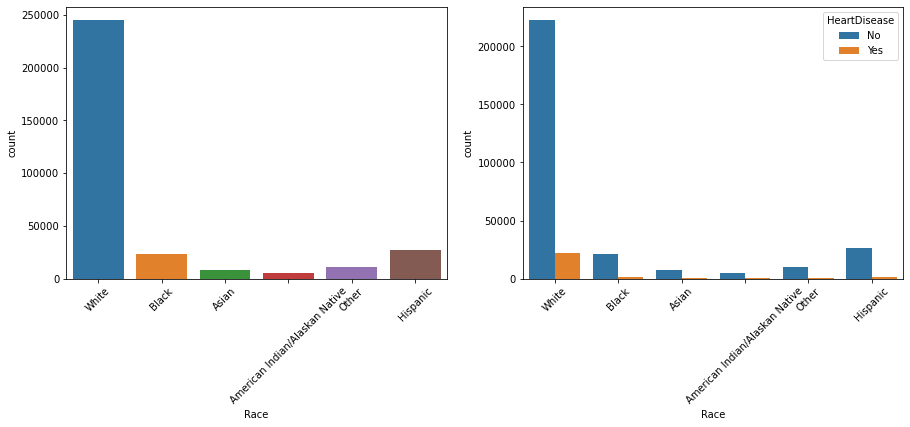

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x = "Race", data = raw_data, ax= ax[0])
sns.countplot(x = "Race", hue = "HeartDisease", data = raw_data, ax= ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 45)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 45)
plt.show

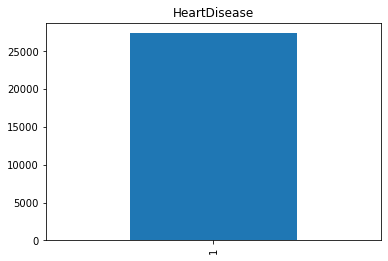

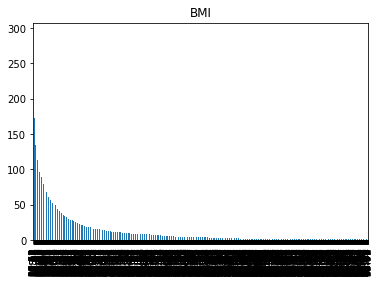

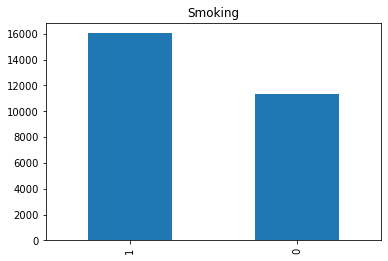

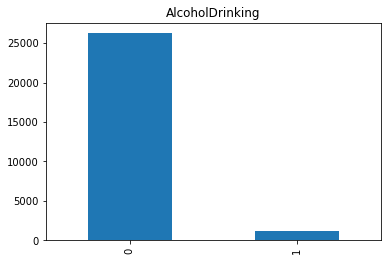

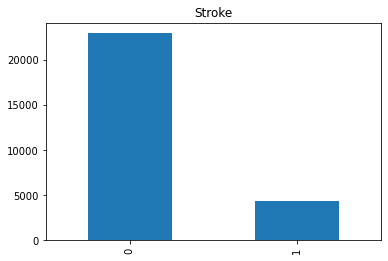

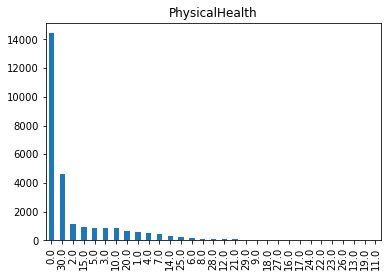

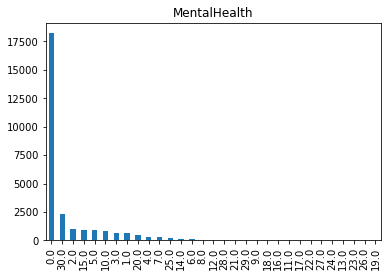

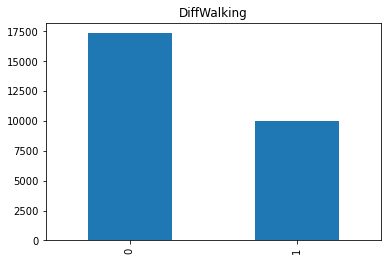

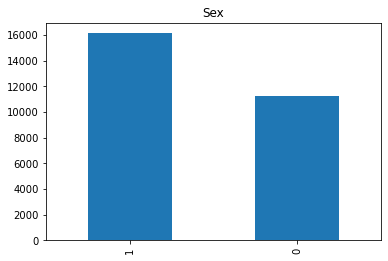

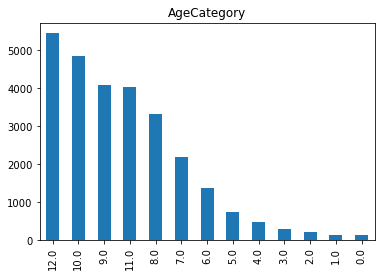

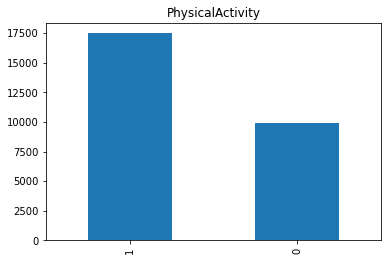

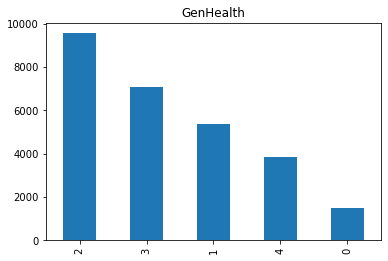

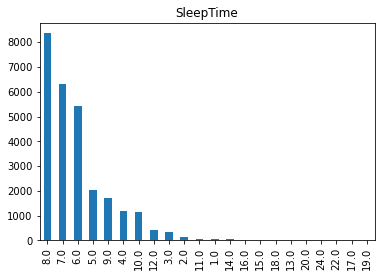

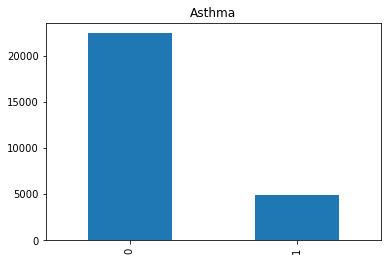

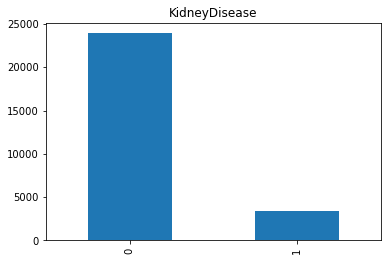

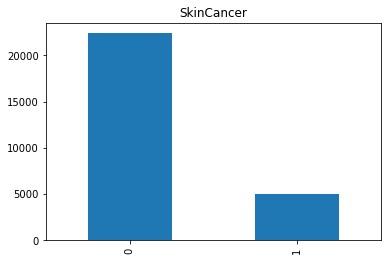

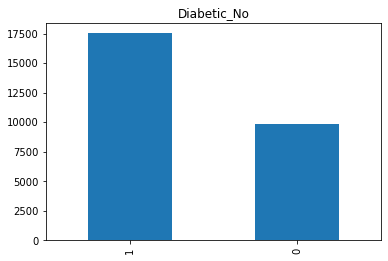

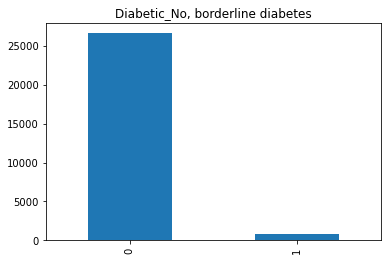

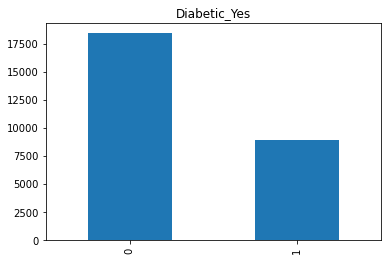

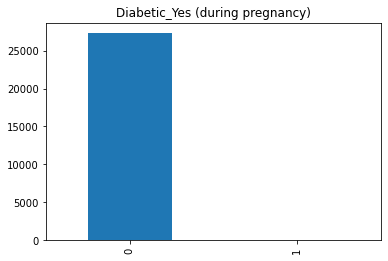

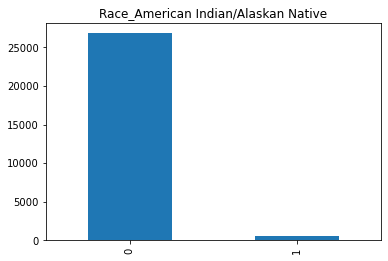

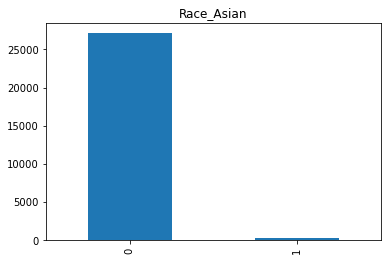

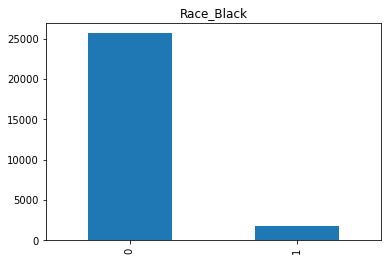

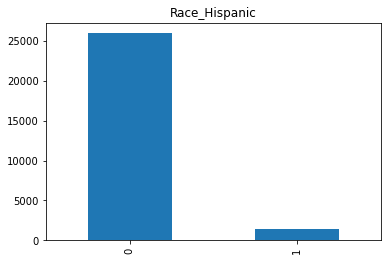

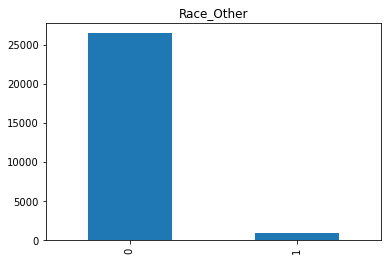

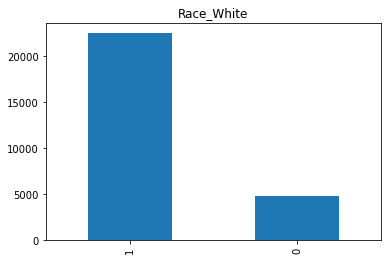

In [112]:
def freq_distribution(data):
    for column in data.columns:
        fig, ax = plt.subplots()
        data[column][data["HeartDisease"]==1].value_counts().plot.bar()
        plt.title(column)
        plt.show()
        
freq_distribution(processed_data)


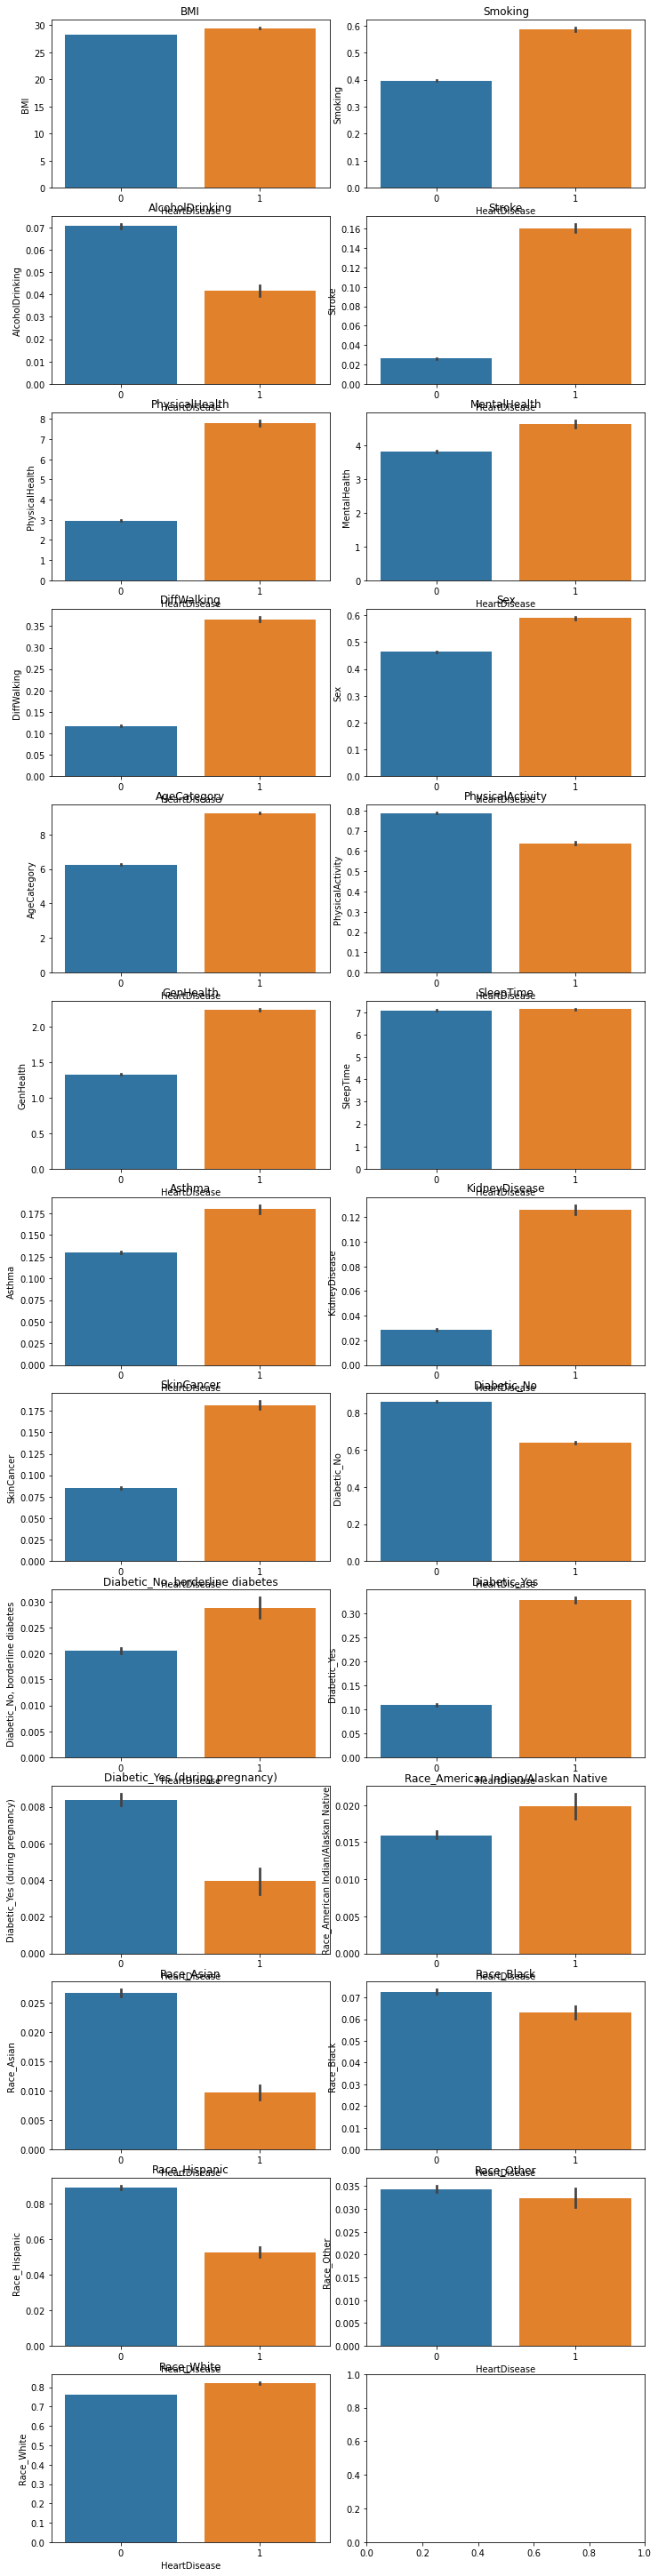

In [238]:
def compare_average(data):
    fig, ax= plt.subplots(13, 2, figsize=(10, 40))
    plt.tight_layout()
    #axes = axes.flatten()
    columns = data.columns
    i = 0
    a = 0
    for column in columns[1:]:
        sns.barplot(x="HeartDisease",
                    y=column, 
                    data=data, 
                      ax=ax[a,i])
        ax[a,i].set_title(column)
        if i == 0:
            i +=1
        elif i % 1 == 0:
            a +=1
            i = 0 
        else:
            i += 1
    
    plt.show()

compare_average(processed_data)

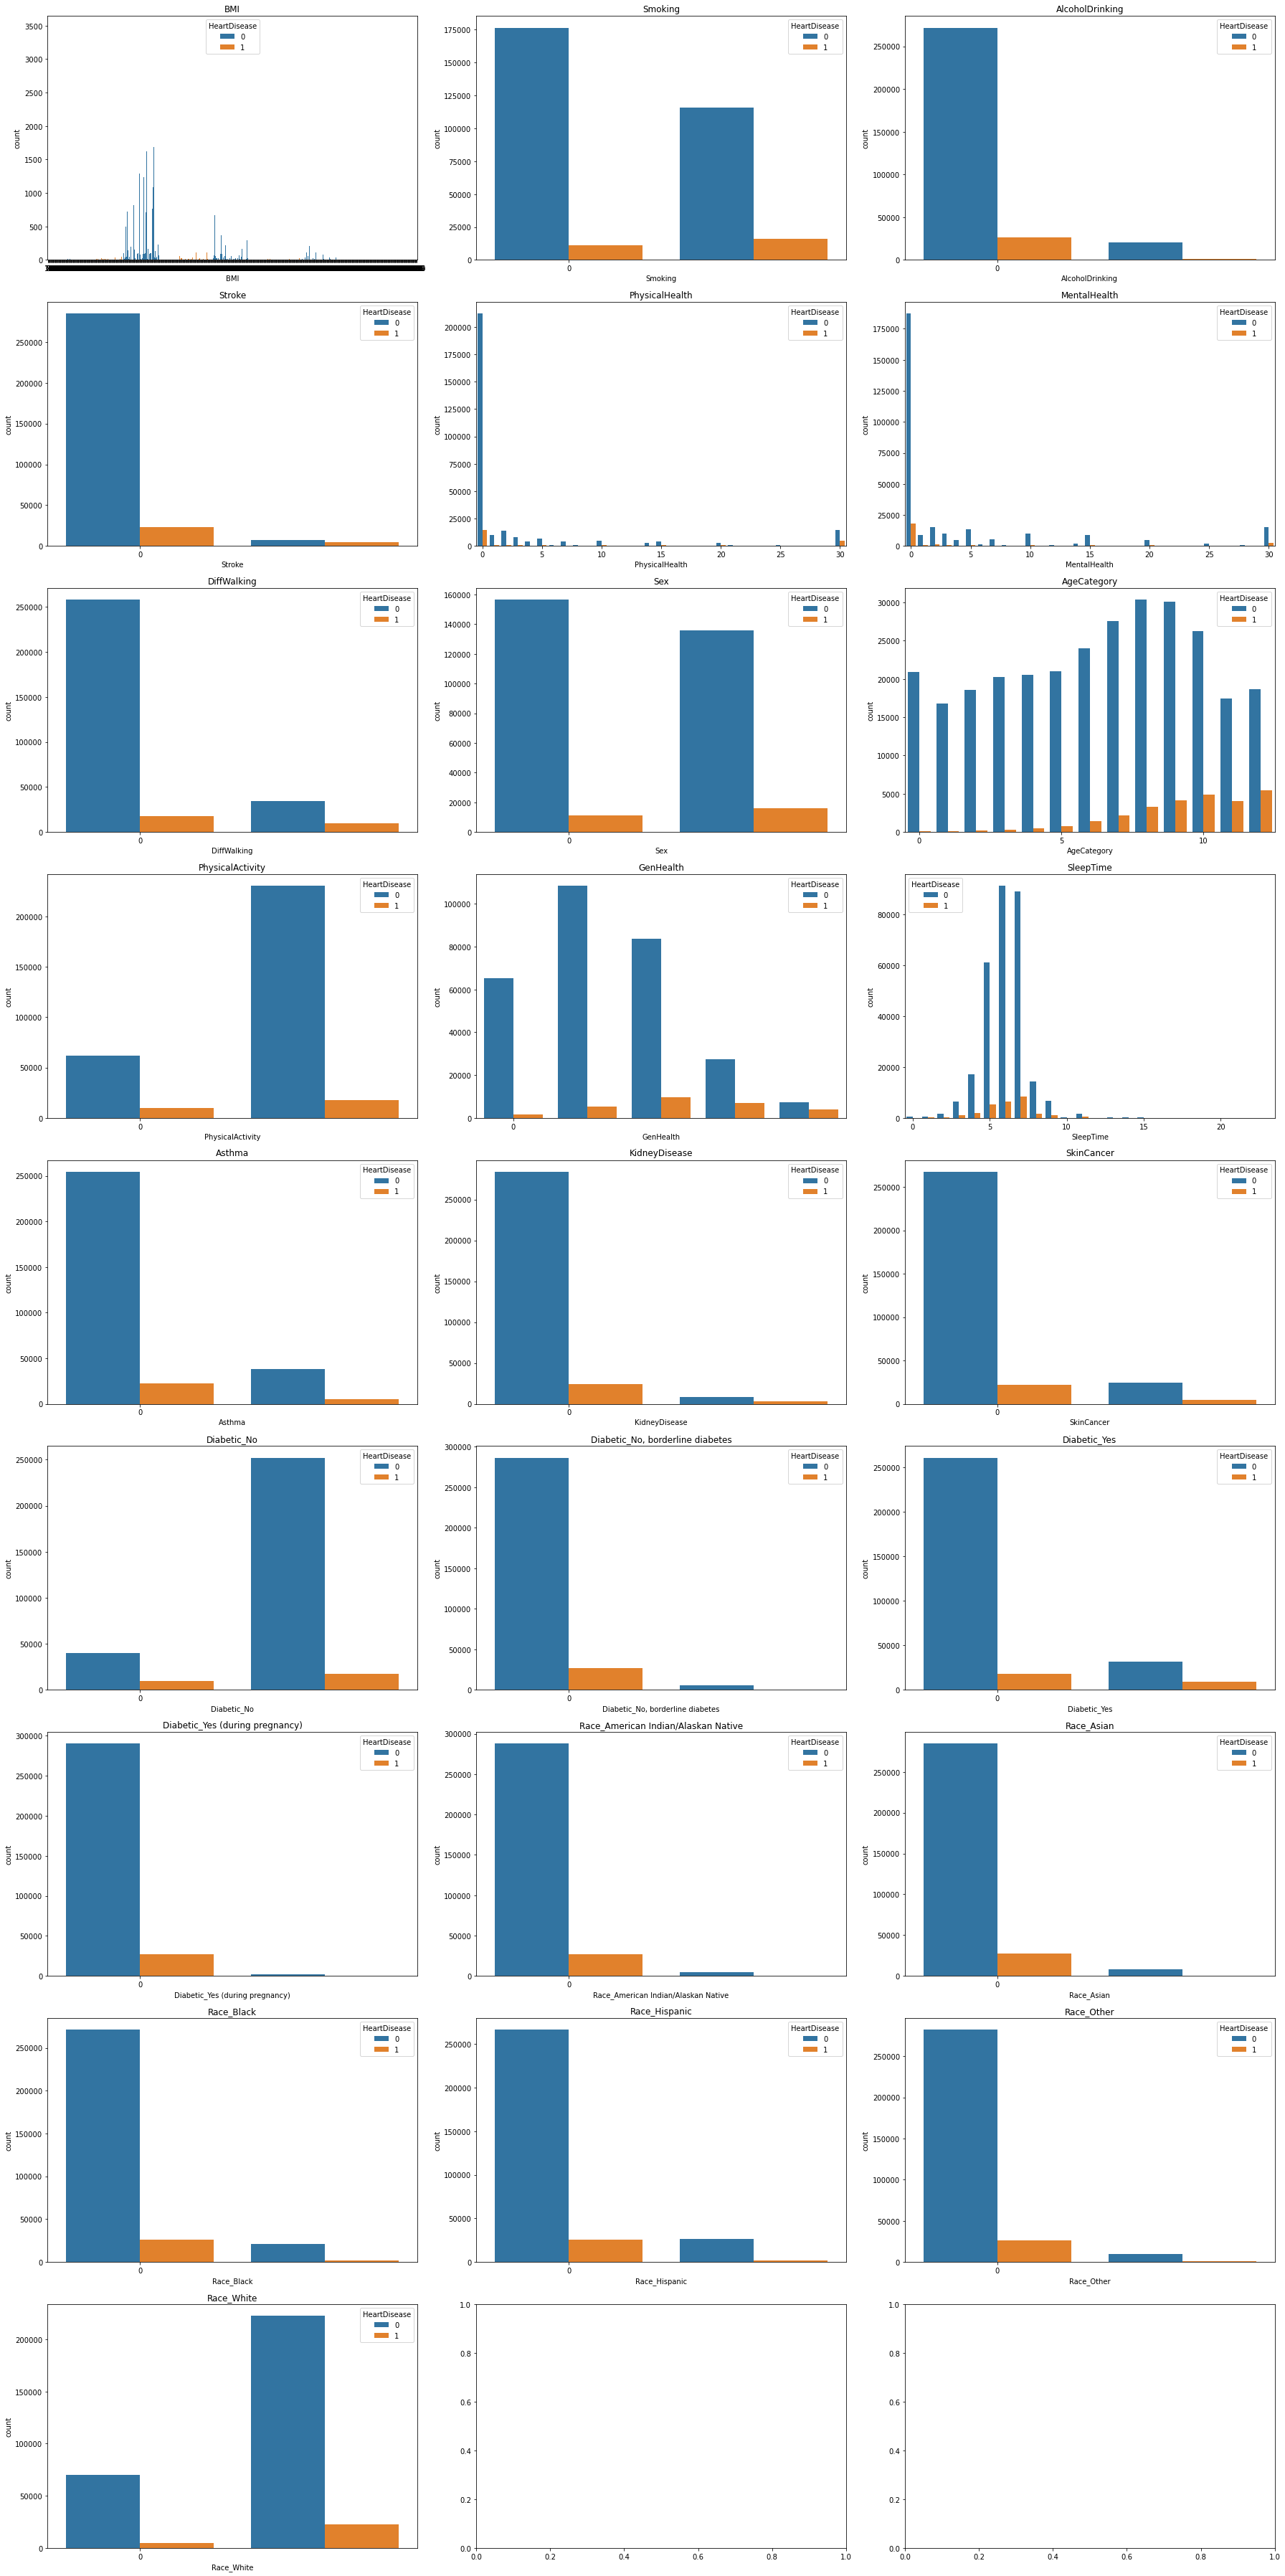

In [36]:
def compare_distrubution(data):
    fig, ax= plt.subplots(9, 3, figsize=(25, 50))
    #axes = axes.flatten()
    columns = data.columns
    i = 0
    a = 0
    for column in columns[1:]:
        sns.countplot(x=column, 
                      hue = "HeartDisease",
                      data=data, 
                      ax=ax[a,i])
        ax[a,i].set_title(column)
        ax[a,i].xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax[a,i].xaxis.set_major_formatter(ticker.ScalarFormatter())
        if i == 0:
            i +=1
        elif i % 2 == 0:
            a +=1
            i = 0 
        else:
            i += 1
    fig.tight_layout()
    plt.show()

compare_distrubution(processed_data)

# test train

In [280]:
# test and train data

def split_train_test(dataset, variable, test_size):
    
    X = dataset.drop([variable], axis=1)
    y = dataset[variable]
 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(processed_data, "HeartDisease", 0.2)

#print(X_train.shape)



#  data normalization or scaling

In [ ]:
#Normalisation
def Min_Max(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    scaled = scaler.fit_transform(data)
    scaled_df = pf.DataFrame(scaled, columns = data.columns)
    return scaled_df


In [10]:
def Standard_Scaler(X_train,X_test):
    sc = StandardScaler()  
    X_train = sc.fit_transform(X_train)  
    X_test = sc.transform(X_test) 
    
    return X_train, X_test

X_train, X_test = Standard_Scaler(X_train,X_test)

# Feature Selection

Text(0.5, 0, 'Feature Importance')

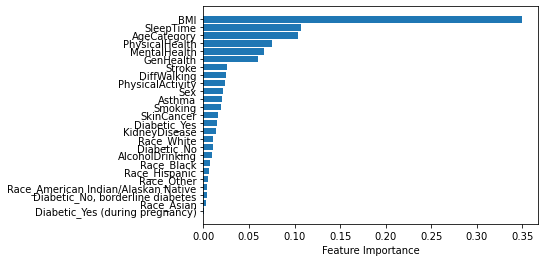

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
sort = rf.feature_importances_.argsort()
X = data.drop(["HeartDisease"], axis=1)
plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance") 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


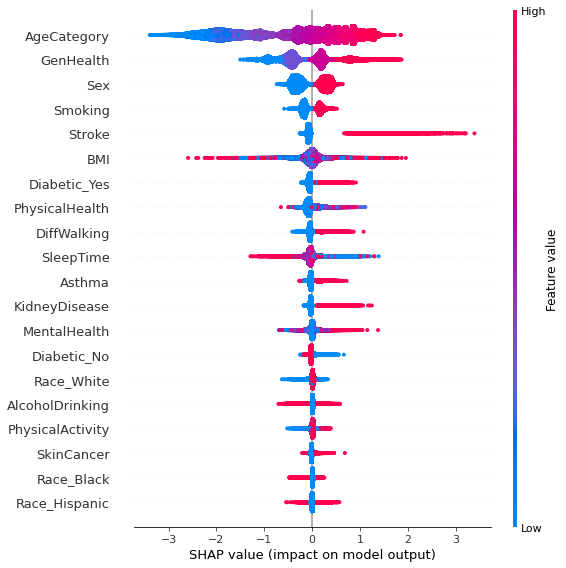

In [62]:
X = data.drop(["HeartDisease"], axis=1)
model = XGBClassifier()
model.fit(X_train, y_train)

#test_1 = X_test[1]
shap.initjs()

shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X)

#shap.force_plot(shap_explainer.expected_value, shap_values[1, :], test_1)
shap.summary_plot(shap_values, X)

100%|===================| 255704/255836 [17:15<00:00]        

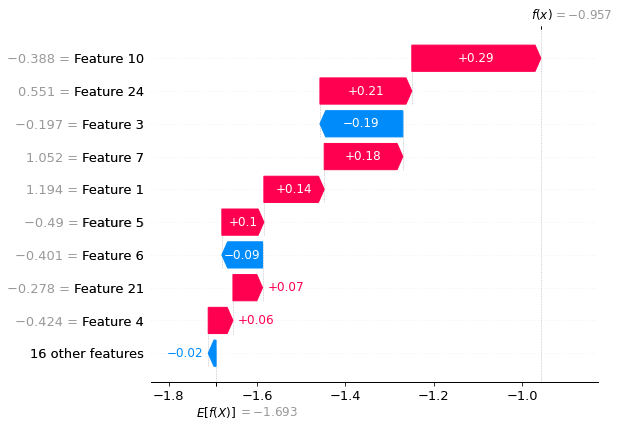

In [68]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

In [296]:
for index, column in enumerate(X.columns):
    print(index, column)

0 BMI
1 Smoking
2 AlcoholDrinking
3 Stroke
4 PhysicalHealth
5 MentalHealth
6 DiffWalking
7 Sex
8 AgeCategory
9 PhysicalActivity
10 GenHealth
11 SleepTime
12 Asthma
13 KidneyDisease
14 SkinCancer
15 Diabetic_No
16 Diabetic_No, borderline diabetes
17 Diabetic_Yes
18 Diabetic_Yes (during pregnancy)
19 Race_American Indian/Alaskan Native
20 Race_Asian
21 Race_Black
22 Race_Hispanic
23 Race_Other
24 Race_White


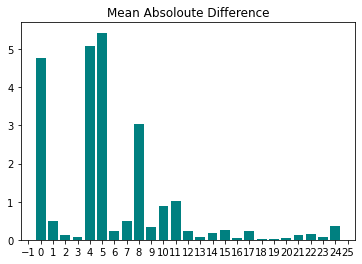

In [260]:
X = processed_data.drop(["HeartDisease"], axis=1)
y = processed_data["HeartDisease"]

mean_abs_diff = np.sum(np.abs(X - np.mean(X, axis = 0)), axis = 0)/X.shape[0]
fig, ax = plt.subplots()
plt.bar(np.arange(X.shape[1]), mean_abs_diff, color = "teal")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.title("Mean Absoloute Difference")

plt.show()

In [300]:
#features_of_importance = ["HeartDisease","Smoking" ,"AgeCategory", "Stroke", "PhysicalHealth","KidneyDisease", "SkinCancer" ,"Diabetic_Yes"]

features_of_importance = ["HeartDisease", "BMI", "Smoking" ,"AgeCategory", 
                          "PhysicalHealth" ,"Diabetic_Yes", "GenHealth"]

smaller_data=processed_data[features_of_importance]
print(smaller_data)

X_train_small, X_test_small, y_train_small, y_test_small = split_train_test(smaller_data, "HeartDisease", 0.2)
#X_train_small, X_test_small = Standard_Scaler(X_train_small, X_test_small)

#X_train_small.shape

        HeartDisease    BMI  Smoking  AgeCategory  PhysicalHealth  \
0                  0  16.60        1          7.0             3.0   
1                  0  20.34        0         12.0             0.0   
2                  0  26.58        1          9.0            20.0   
3                  0  24.21        0         11.0             0.0   
4                  0  23.71        0          4.0            28.0   
...              ...    ...      ...          ...             ...   
319790             1  27.41        1          8.0             7.0   
319791             0  29.84        1          3.0             0.0   
319792             0  24.24        0          5.0             0.0   
319793             0  32.81        0          1.0             0.0   
319794             0  46.56        0         12.0             0.0   

        Diabetic_Yes  GenHealth  
0                  1          1  
1                  0          1  
2                  1          3  
3                  0          2  
4

# Data Balancing techniques
# Method 1 undersampling

In [13]:
def undersample_nearmiss(X,y):
    
    nearmiss = NearMiss()
    X_nm, y_nm = nearmiss.fit_resample(X, y)
    print('near miss Resampled dataset shape %s' % collections.Counter(y_nm))
    return X_nm, y_nm

#X_nm, y_nm = undersample_nearmiss(X_train, y_train)

# Method 2 Random Oversample

In [14]:
def oversample_random(X,y):
    
    oversam = RandomOverSampler()
    X_over, y_over = oversam.fit_resample(X, y)
    print('oversample Resampled dataset shape %s' % collections.Counter(y_over))
    return X_over, y_over

#X_over, y_over = oversample_random(X_train, y_train)

# Method 3 Random Undersample and EEN Oversample

In [15]:
def oversample_ENN(X, y, sample_type):
    
    sme = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy=sample_type),
                   random_state=42)
    X_ENN, y_ENN = sme.fit_resample(X, y)
    print('ENN Resampled dataset shape %s' % Counter(y_ENN))
    
    return X_ENN, y_ENN
    
#X_EEN, y_EEN = oversample_ENN(X_res, y_res)


In [16]:
def undersampleENN_random(X, y, sample_percentage, sample_type):
    
    org_size = collections.Counter(y)
    #print('Original dataset shape %s' % org_size)
    
    smaller_0 = org_size.get(1)*sample_percentage
    
    rus = under_sampling.RandomUnderSampler(
        sampling_strategy={
            0: int(smaller_0),
            1: int(org_size.get(1)),
        },
        random_state=42
    )
    X_res, y_res = rus.fit_resample(X, y)
    
    print('Undersample part Resampled dataset shape %s' % collections.Counter(y_res))
    #return X_res, y_res
    
    X_ENN, y_ENN= oversample_ENN(X_res, y_res,sample_type)
    
    return X_ENN, y_ENN
    

#X_res, y_res=undersample(X_train, y_train, 1.5)

# Test different balancing techniques

In [17]:
def original(X, y):
    print('original dataset shape %s' % Counter(y))
    return X, y


In [110]:
functions = [original(X_train, y_train), undersample_nearmiss(X_train,y_train), oversample_random(X_train, y_train), 
             undersampleENN_random(X_train, y_train, 1.5, "all")
             #,oversample_EEN(X_train, y_train)
            ]

for function in functions:
    X, y = function

    model = XGBClassifier()
    model.fit(X, y)
    y_pred = model.predict(X_test) 

    print(accuracy_score(y_test, y_pred)) 
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred,target_names = ["No Heart Disease", "Heart Disease"]))

original dataset shape Counter({0: 234055, 1: 21781})
near miss Resampled dataset shape Counter({0: 21781, 1: 21781})
oversample Resampled dataset shape Counter({0: 234055, 1: 234055})
Undersample part Resampled dataset shape Counter({0: 32671, 1: 21781})
Resampled dataset shape Counter({1: 17275, 0: 16000})
0.8637251989555809
[[53834  4533]
 [ 4183  1409]]
                  precision    recall  f1-score   support

No Heart Disease       0.93      0.92      0.93     58367
   Heart Disease       0.24      0.25      0.24      5592

        accuracy                           0.86     63959
       macro avg       0.58      0.59      0.58     63959
    weighted avg       0.87      0.86      0.87     63959

0.26509169936990884
[[12205 46162]
 [  842  4750]]
                  precision    recall  f1-score   support

No Heart Disease       0.94      0.21      0.34     58367
   Heart Disease       0.09      0.85      0.17      5592

        accuracy                           0.27     63959
    

selected random undersampling with EEN oversampling, now testing full dataset vs feature selected dataset

In [18]:
#full dataset - balanced
original(X_train, y_train)

X_train_ENN, y_train_ENN =undersampleENN_random(
    X_train, y_train, 1.5, "all")


original dataset shape Counter({0: 234055, 1: 21781})
Undersample part Resampled dataset shape Counter({0: 32671, 1: 21781})
ENN Resampled dataset shape Counter({1: 16965, 0: 16198})


In [19]:
#full dataset - oversampled heart disease
original(X_train, y_train)

X_train_ENN_over, y_train_ENN_over =undersampleENN_random(
    X_train, y_train, 1.5, "majority")


original dataset shape Counter({0: 234055, 1: 21781})
Undersample part Resampled dataset shape Counter({0: 32671, 1: 21781})
ENN Resampled dataset shape Counter({1: 32671, 0: 16198})


In [301]:
# feature selected dataset -balanced
original(X_train_small, y_train_small)
print(X_train_small.shape)


X_train_small_ENN, y_train_small_ENN= undersampleENN_random(
    X_train_small, y_train_small, 1.5, "all")

original dataset shape Counter({0: 234055, 1: 21781})
(255836, 6)
Undersample part Resampled dataset shape Counter({0: 32671, 1: 21781})
ENN Resampled dataset shape Counter({0: 16747, 1: 14728})


when edditednearestneigbour is applied with SMOTEENN for fulldataset heart disease actually becomes majority compared to non heartdisease. without this argument for the feature selected dataset the heatdisease category is far too small still


# Brief comparision of how each variation is reflected in terms of precision and recall

0.9134445504151096


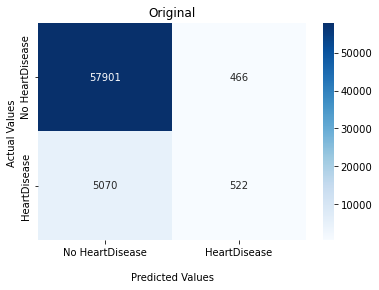

0.7346581403711753


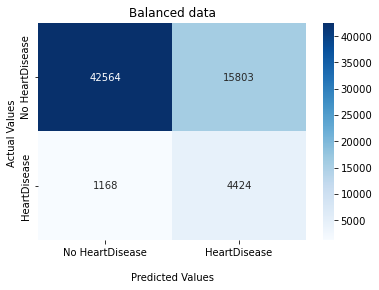

0.6127831892306008


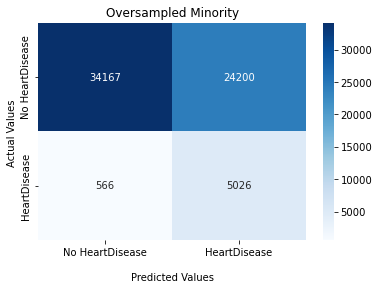

0.7053737550618365


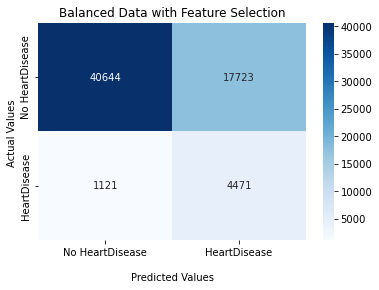

In [19]:
#select a model and show confusion matrix

def confusion_matrixes(title,X_train, y_train, X_test, y_test):
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 

    print(accuracy_score(y_test, y_pred)) 
    cm = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt = "d")
    ax.set_title(title)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['No HeartDisease','HeartDisease'])
    ax.yaxis.set_ticklabels(['No HeartDisease','HeartDisease'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()


confusion_matrixes("Original",X_train, y_train, X_test, y_test)
confusion_matrixes("Balanced data",X_train_ENN, y_train_ENN, X_test, y_test)
confusion_matrixes("Oversampled Minority",X_train_ENN_over, y_train_ENN_over, X_test, y_test)
confusion_matrixes("Balanced Data with Feature Selection",X_train_small_ENN, y_train_small_ENN, X_test_small, y_test_small)

# Anomoly detection 

In [286]:
def remove_anomoly(algorithm, X_train, y_train):
    print(X_train.shape, y_train.shape)
    iso = algorithm
    model = iso.fit_predict(X_train)
    mask = model != -1
    X_trainnew, y_trainnew= X_train[mask, :], y_train[mask]
    print(X_trainnew.shape, y_trainnew.shape)
    return X_trainnew, y_trainnew
  
    
#X_train_ENN, y_train_ENN=remove_anomoly(OneClassSVM(nu = 0.01), X_train_ENN, y_train_ENN)


X_train_small_ENN, y_train_small_ENN=remove_anomoly(OneClassSVM(nu = 0.01), X_train_small_ENN, y_train_small_ENN)

(31054, 6) (31054,)
(30747, 6) (30747,)


In [66]:
#an example showing how anolmoy removal will improve model

print(X_train_ENN.shape, y_train_ENN.shape)
iso = IsolationForest(contamination = 0.1)
model = iso.fit_predict(X_train_ENN)
mask = model != -1
X_trainnew, y_trainnew = X_train_ENN[mask, :], y_train_ENN[mask]

print(X_trainnew.shape, y_trainnew.shape)

model2 = XGBClassifier()
model2.fit(X_trainnew, y_trainnew)
y_pred = model2.predict(X_test)
print(model2)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(
    y_test, y_pred, 
    target_names = ["No Heart Disease", "Heart Disease"]))

(33163, 25) (33163,)
(29846, 25) (29846,)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
[[42607 15760]
 [ 1192  4400]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.73      0.83     58367
   Heart Disease       0.22      0.79      0.34      5592

        accuracy                           0.73     

# Basic Test of ML algorithms

In [31]:
#basic function to quickly run models based on our different training data

def print_results(classifers, X_train, y_train, X_test, y_test):
    
    for algorithm in classifers:
        algorithm.fit(X_train, y_train)
        y_pred = algorithm.predict(X_test)
        print(algorithm)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        print(classification_report(
            y_test, y_pred, 
            target_names = ["No Heart Disease", "Heart Disease"]))

In [298]:
#print("example of unbalanced data poor precision and recall for minority class")
classifer = [XGBClassifier()]
#print_results(classifer,  X_train, y_train, X_test, y_test)

In [299]:
print("imblanced dataset with balancing algorithms")
classifiers = [LogisticRegression(max_iter = 500, class_weight = "balanced")]

print_results(classifiers,X_train, y_train, X_test, y_test)

imblanced dataset with balancing algorithms
LogisticRegression(class_weight='balanced', max_iter=500)
[[43661 14706]
 [ 1249  4343]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.75      0.85     58367
   Heart Disease       0.23      0.78      0.35      5592

        accuracy                           0.75     63959
       macro avg       0.60      0.76      0.60     63959
    weighted avg       0.91      0.75      0.80     63959



In [234]:
print("full dataset-blanced")
classifiers1 = [GaussianNB(), LogisticRegression(),
                RandomForestClassifier(), DecisionTreeClassifier(), 
               KNeighborsClassifier(), XGBClassifier()]

#note SVC takes to long to calculate
print_results(classifiers1,X_train_ENN, y_train_ENN, X_test, y_test)

full dataset-blanced
GaussianNB()
[[41498 16869]
 [ 1679  3913]]
                  precision    recall  f1-score   support

No Heart Disease       0.96      0.71      0.82     58367
   Heart Disease       0.19      0.70      0.30      5592

        accuracy                           0.71     63959
       macro avg       0.57      0.71      0.56     63959
    weighted avg       0.89      0.71      0.77     63959

LogisticRegression()
[[40801 17566]
 [  974  4618]]
                  precision    recall  f1-score   support

No Heart Disease       0.98      0.70      0.81     58367
   Heart Disease       0.21      0.83      0.33      5592

        accuracy                           0.71     63959
       macro avg       0.59      0.76      0.57     63959
    weighted avg       0.91      0.71      0.77     63959

RandomForestClassifier()
[[41800 16567]
 [ 1144  4448]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.72      0.83     58367
   Heart

In [287]:
print("feature selected dataset-sampled")
classifiers = [GaussianNB(), LogisticRegression(),
                RandomForestClassifier(), DecisionTreeClassifier(), 
               KNeighborsClassifier(), XGBClassifier()]

#note SVC takes to long to calculate
print_results(classifiers,X_train_small_ENN, y_train_small_ENN, X_test_small, y_test_small)

feature selected dataset-sampled
GaussianNB()
[[44983 13384]
 [ 2059  3533]]
                  precision    recall  f1-score   support

No Heart Disease       0.96      0.77      0.85     58367
   Heart Disease       0.21      0.63      0.31      5592

        accuracy                           0.76     63959
       macro avg       0.58      0.70      0.58     63959
    weighted avg       0.89      0.76      0.81     63959

LogisticRegression()
[[41213 17154]
 [ 1232  4360]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.71      0.82     58367
   Heart Disease       0.20      0.78      0.32      5592

        accuracy                           0.71     63959
       macro avg       0.59      0.74      0.57     63959
    weighted avg       0.90      0.71      0.77     63959

RandomForestClassifier()
[[40690 17677]
 [ 1380  4212]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.70      0.81     58

# Grid Search

In [86]:
def grid_search(model, grid_params, X, y):
    
    grid_search = GridSearchCV(model,
                          grid_params,
                          verbose = 1,
                          cv = 3,
                          n_jobs = -1
                          )

    results = grid_search.fit(X, y)
    print(results.best_score_)
    print(results.best_estimator_)
    print(results.best_params_)

In [ ]:
grid_params_KNN = {
    "n_neighbors": [3,5,11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}


grid_params_DT = {
    "max_depth": [15, 20],
    "min_samples_split": [10, 15],
    "max_features": [18, 24]
}

In [47]:
grid_search(KNeighborsClassifier(), grid_params_KNN, X_train_ENN, y_train_ENN)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.9777462971068852
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [48]:
grid_search(DecisionTreeClassifier(), grid_params_DT, X_train_ENN, y_train_ENN)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.940385538247324
DecisionTreeClassifier(max_depth=15, max_features=24, min_samples_split=15)
{'max_depth': 15, 'max_features': 24, 'min_samples_split': 15}


In [34]:
classifers = [DecisionTreeClassifier(max_depth=15, max_features=24, min_samples_split=15)
,KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')]

print_results(classifers, X_train_ENN, y_train_ENN, X_test, y_test)

DecisionTreeClassifier(max_depth=15, max_features=24, min_samples_split=15)
[[41953 16414]
 [ 1251  4341]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.72      0.83     58367
   Heart Disease       0.21      0.78      0.33      5592

        accuracy                           0.72     63959
       macro avg       0.59      0.75      0.58     63959
    weighted avg       0.90      0.72      0.78     63959

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
[[40767 17600]
 [ 1238  4354]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.70      0.81     58367
   Heart Disease       0.20      0.78      0.32      5592

        accuracy                           0.71     63959
       macro avg       0.58      0.74      0.56     63959
    weighted avg       0.90      0.71      0.77     63959



Grid search for feature selected data 

In [227]:
grid_search(KNeighborsClassifier(), grid_params_KNN, X_train_small_ENN, y_train_small_ENN)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.9356557460394931
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [96]:
grid_params_DT = {
    "max_depth": [15, 25],
    "min_samples_split": [5, 10],
    "max_features": [3, 7]
}
grid_search(DecisionTreeClassifier(), grid_params_DT,  X_train_small_ENN, y_train_small_ENN)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.7487312075074213
DecisionTreeClassifier(max_depth=15, max_features=3, min_samples_split=5)
{'max_depth': 15, 'max_features': 3, 'min_samples_split': 5}


In [288]:
classifers = [DecisionTreeClassifier(max_depth=15, max_features=3, min_samples_split=5)
,KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')]

print_results(classifers,  X_train_small_ENN, y_train_small_ENN, X_test_small, y_test_small)

DecisionTreeClassifier(max_depth=15, max_features=3, min_samples_split=5)
[[41323 17044]
 [ 1437  4155]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.71      0.82     58367
   Heart Disease       0.20      0.74      0.31      5592

        accuracy                           0.71     63959
       macro avg       0.58      0.73      0.56     63959
    weighted avg       0.90      0.71      0.77     63959

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
[[40655 17712]
 [ 1442  4150]]
                  precision    recall  f1-score   support

No Heart Disease       0.97      0.70      0.81     58367
   Heart Disease       0.19      0.74      0.30      5592

        accuracy                           0.70     63959
       macro avg       0.58      0.72      0.56     63959
    weighted avg       0.90      0.70      0.77     63959



# Cross Validation on best models

In [216]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

scorings = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

def cross_validate_results(models, X, y):
    for model in models:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        results = cross_validate(estimator=model,
                                              X=X,
                                              y=y,
                                              cv=cv,
                                              scoring=scorings)
        print(model)
        #print(results)
        for value in results:
            print(np.mean(results[value]))



In [302]:
model = [DecisionTreeClassifier(max_depth=15, max_features=24, min_samples_split=15), XGBClassifier()]
modelfs = [GaussianNB(), LogisticRegression(max_iter = 500), DecisionTreeClassifier(max_depth=15, max_features=3, min_samples_split=5),KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')]
modellog = [LogisticRegression(class_weight = "balanced", max_iter = 500)]


print("LogReg for Unbalanced data\n")
cross_validate_results(modellog, X_train, y_train)

print("\nCrossvalidation for full balanced dataset\n")
cross_validate_results(model, X_train_ENN, y_train_ENN)

print("\nCrossvalidation for feature selected balanced dataset\n")
cross_validate_results(modelfs, X_train_small_ENN, y_train_small_ENN)



LogReg for Unbalanced data

LogisticRegression(class_weight='balanced', max_iter=500)
7.047870572408041
0.05513606071472168
0.7519569803227525
0.224600064229607
0.7802059199319616
0.3487893878454462

Crossvalidation for full balanced dataset

DecisionTreeClassifier(max_depth=15, max_features=24, min_samples_split=15)
0.10287632942199706
0.008173497517903645
0.9475797188620613
0.9509798813892535
0.94587115105037
0.9484091349809295
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone

# Recursive Feature Elimination

In [235]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
score_metrics = ['accuracy', 'average_precision', 'f1', 'precision','recall', 'roc_auc']

n_scores = cross_validate(pipeline, X_train_ENN, y_train_ENN, scoring= score_metrics, cv=cv, n_jobs=-1, error_score='raise')


# report performance
#print(n_scores) 


In [99]:
df_cv_result = pd.DataFrame(n_scores)
df_cv_result.head()

,fit_time,score_time,test_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc
0,3.256389,0.033562,0.906951,0.877033,0.908194,0.912917,0.903519,0.909926
1,2.846300,0.024000,0.923537,0.904217,0.924303,0.932294,0.916447,0.930054
2,2.984920,0.034528,0.916341,0.887199,0.917706,0.919692,0.915729,0.918277
3,3.276042,0.033047,0.911209,0.880788,0.912605,0.915022,0.910201,0.913508
4,2.932305,0.044617,0.917195,0.895517,0.918005,0.926170,0.909983,0.923198


In [219]:
for value in n_scores:
    print(np.mean(n_scores[value]))

3.4777312437693277
0.032706626256306964
0.9184629278084977
0.8956269210092204
0.9194049979500019
0.9259637888697123
0.912970371616258
0.9239766690063363


# ROC CURVE

Non-Feature Selected data with XGBClassifer
ML: ROC AUC=0.833


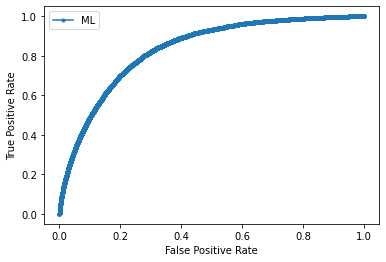

In [125]:
def roc_curve_plot(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    print('ML: ROC AUC=%.3f' % (auc))
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    #plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='ML')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
  
    plt.legend()
    plt.show()

print("Non-Feature Selected data with XGBClassifer")
roc_curve(XGBClassifier(), X_train_ENN, y_train_ENN, X_test, y_test)

Feature Selected data with GaussianNB
ML: ROC AUC=0.790


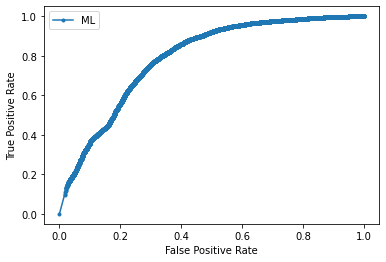

In [290]:
print("Feature Selected data with GaussianNB")
roc_curve_plot(GaussianNB(), X_train_small_ENN, y_train_small_ENN, X_test_small, y_test_small)

Feature Selected data with KNNeigbours
ML: ROC AUC=0.739


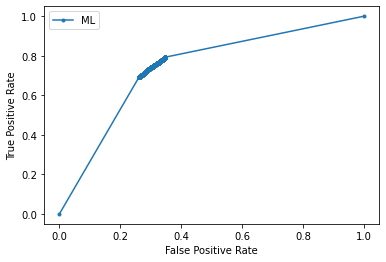

In [291]:
print("Feature Selected data with KNNeigbours")
roc_curve_plot(KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance'), X_train_small_ENN, y_train_small_ENN, X_test_small, y_test_small)

# Example of changing positive threshold to  Increase specificity (reduce false negative)

[2.72789412e-04 8.77317184e-05 1.17396572e-02 ... 4.67748305e-03
 2.14058468e-01 9.99874470e-01]


Text(0, 0.5, 'Frequency')

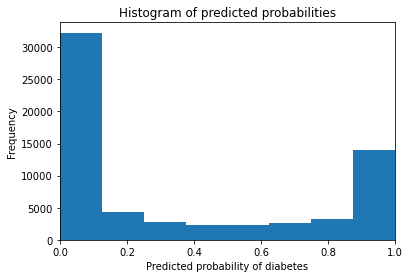

In [232]:
from sklearn.preprocessing import binarize
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train_ENN, y_train_ENN)
logreg.predict_proba(X_test)[0:10, 1]

y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_class = logreg.predict(X_test)

print(y_pred_prob)

plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')


In [274]:

def binarize_item(y_pred, threshold):
    
    y_pred_prob=y_pred.reshape(1, -1)
    y_pred_class = binarize(y_pred_prob, threshold= threshold)[0]
    
    return y_pred_class

    
    
pred_classes=[y_pred_class, binarize_item(y_pred_prob, 0.4), binarize_item(y_pred_prob, 0.3)]

for pred in pred_classes:
    print(metrics.confusion_matrix(y_test_small, pred))
    print(metrics.accuracy_score(y_test_small, pred))


[[40801 17566]
 [  974  4618]]
0.710126799981238
[[39174 19193]
 [  835  4757]]
0.6868618959020623
[[36863 21504]
 [  673  4919]]
0.6532622461264247


# Neural Network

In [49]:
model = keras.Sequential([
    layers.Dense(8, activation = "relu",input_shape =(25,)),
    layers.Dense(52, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])


In [50]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

In [47]:
org_size = collections.Counter(y_train) 

n_classes= 2 
n_sample0= int(org_size.get(0))
n_sample1= int(org_size.get(1))
n_samples= n_sample0 + n_sample1
    

#Weights for class 0 (no heart disease):
w0=  n_samples/(n_classes*n_sample0) 

#Weights for class 1 (heart disease):
w1= n_samples/(n_classes*n_sample1)

class_weights = {0:w0*2, 1: w1*2}
print(org_size)
print(class_weights)

Counter({0: 234055, 1: 21781})
{0: 1.0930593236632415, 1: 11.745833524631559}


In [51]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

BATCH_SIZE= 512

history_class_weight = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
500/500 [==============================] - 12s 16ms/step - loss: 1.0454 - tp: 16979.0000 - fp: 68508.0000 - tn: 165547.0000 - fn: 4802.0000 - accuracy: 0.7134 - precision: 0.1986 - recall: 0.7795 - auc: 0.8175 - prc: 0.3052 - val_loss: 0.5246 - val_tp: 4545.0000 - val_fp: 17485.0000 - val_tn: 40882.0000 - val_fn: 1047.0000 - val_accuracy: 0.7103 - val_precision: 0.2063 - val_recall: 0.8128 - val_auc: 0.8326 - val_prc: 0.3305
Epoch 2/50
500/500 [==============================] - 6s 11ms/step - loss: 0.9907 - tp: 17664.0000 - fp: 67064.0000 - tn: 166991.0000 - fn: 4117.0000 - accuracy: 0.7218 - precision: 0.2085 - recall: 0.8110 - auc: 0.8379 - prc: 0.3362 - val_loss: 0.5397 - val_tp: 4618.0000 - val_fp: 17755.0000 - val_tn: 40612.0000 - val_fn: 974.0000 - val_accuracy: 0.7072 - val_precision: 0.2064 - val_recall: 0.8258 - val_auc: 0.8358 - val_prc: 0.3352
Epoch 3/50
500/500 [==============================] - 6s 11ms/step - loss: 0.9817 - tp: 17699.0000 - fp: 65864.0000 - tn: 

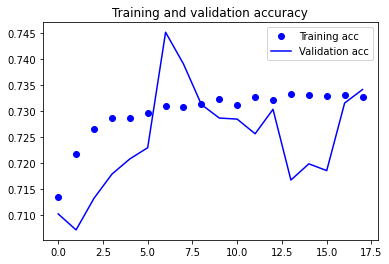

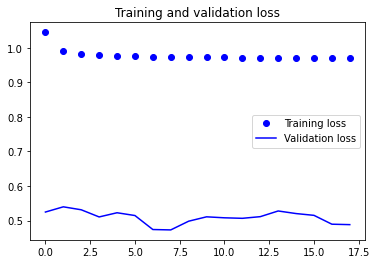

In [52]:
def  produce_graph(history1):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
produce_graph(history_class_weight)

In [53]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        fig= plt.subplots(figsize=(10, 10))
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric],  label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                  linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
#plot_metrics(history_class_weights)    

In [80]:
def print_total_results(model, X_test, y_test):
    baseline_results = model.evaluate(X_test, y_test,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)

print_total_results(model, X_test, y_test)


loss :  0.938101053237915
tp :  4614.0
fp :  17453.0
tn :  40914.0
fn :  978.0
accuracy :  0.7118310332298279
precision :  0.20909050107002258
recall :  0.8251072764396667
auc :  0.8367807269096375
prc :  0.30852198600769043


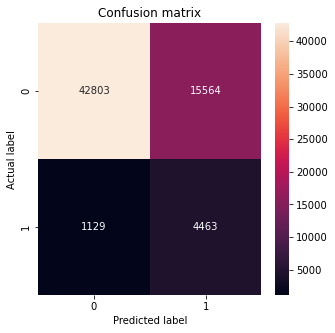

In [56]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

In [61]:
model2 = keras.Sequential([
    layers.Dense(8, activation = "relu",input_shape =(25,)),
    layers.Dense(52, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])


In [62]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

In [63]:
history_pre_balanced = model2.fit(
    X_train_ENN, y_train_ENN,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
65/65 [==============================] - 9s 71ms/step - loss: 0.3290 - tp: 19289.0000 - fp: 20233.0000 - tn: 54226.0000 - fn: 3010.0000 - accuracy: 0.7598 - precision: 0.4881 - recall: 0.8650 - auc: 0.8603 - prc: 0.5908 - val_loss: 0.9412 - val_tp: 4475.0000 - val_fp: 19555.0000 - val_tn: 38812.0000 - val_fn: 1117.0000 - val_accuracy: 0.6768 - val_precision: 0.1862 - val_recall: 0.8003 - val_auc: 0.8025 - val_prc: 0.2717
Epoch 2/50
65/65 [==============================] - 3s 39ms/step - loss: 0.1997 - tp: 15387.0000 - fp: 1365.0000 - tn: 14727.0000 - fn: 1320.0000 - accuracy: 0.9181 - precision: 0.9185 - recall: 0.9210 - auc: 0.9756 - prc: 0.9769 - val_loss: 0.8940 - val_tp: 4480.0000 - val_fp: 18005.0000 - val_tn: 40362.0000 - val_fn: 1112.0000 - val_accuracy: 0.7011 - val_precision: 0.1992 - val_recall: 0.8011 - val_auc: 0.8168 - val_prc: 0.2890
Epoch 3/50
65/65 [==============================] - 3s 41ms/step - loss: 0.1698 - tp: 15641.0000 - fp: 1194.0000 - tn: 14898.0000

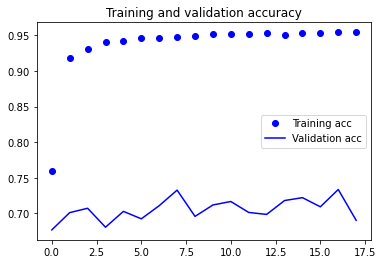

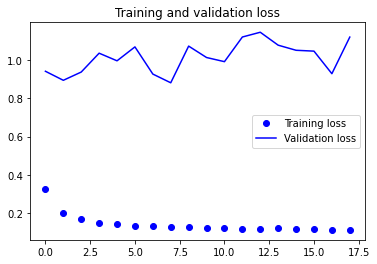

In [64]:
produce_graph(history_pre_balanced)

In [65]:
print_total_results(model2, X_test, y_test)

loss :  0.8810780644416809
tp :  4443.0
fp :  15947.0
tn :  42420.0
fn :  1149.0
accuracy :  0.7327037453651428
precision :  0.21790093183517456
recall :  0.7945278882980347
auc :  0.8302078247070312
prc :  0.3001527488231659


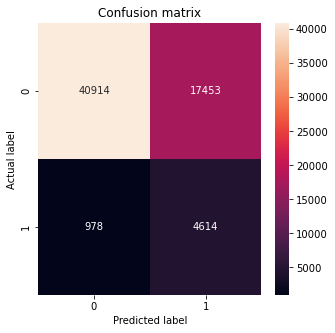

In [60]:
test_predictions_baseline = model2.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

In [75]:
model3 = keras.Sequential([
    layers.Dense(8, activation = "relu",input_shape =(7,)),
    layers.Dense(52, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

In [76]:
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

In [77]:

history3 = model3.fit(
    X_train_small, y_train_small,
    validation_data=(X_test_small, y_test_small),
    batch_size=BATCH_SIZE,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
500/500 [==============================] - 18s 28ms/step - loss: 1.0934 - tp: 21778.0000 - fp: 98689.0000 - tn: 193733.0000 - fn: 5595.0000 - accuracy: 0.6739 - precision: 0.1808 - recall: 0.7956 - auc: 0.7945 - prc: 0.2439 - val_loss: 0.5684 - val_tp: 4715.0000 - val_fp: 22371.0000 - val_tn: 35996.0000 - val_fn: 877.0000 - val_accuracy: 0.6365 - val_precision: 0.1741 - val_recall: 0.8432 - val_auc: 0.8063 - val_prc: 0.2838
Epoch 2/50
500/500 [==============================] - 12s 24ms/step - loss: 1.0557 - tp: 17348.0000 - fp: 76379.0000 - tn: 157676.0000 - fn: 4433.0000 - accuracy: 0.6841 - precision: 0.1851 - recall: 0.7965 - auc: 0.8102 - prc: 0.2855 - val_loss: 0.5173 - val_tp: 4351.0000 - val_fp: 18047.0000 - val_tn: 40320.0000 - val_fn: 1241.0000 - val_accuracy: 0.6984 - val_precision: 0.1943 - val_recall: 0.7781 - val_auc: 0.8109 - val_prc: 0.3004
Epoch 3/50
500/500 [==============================] - 12s 24ms/step - loss: 1.0504 - tp: 17315.0000 - fp: 75076.0000 - tn

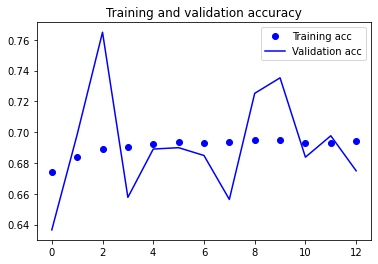

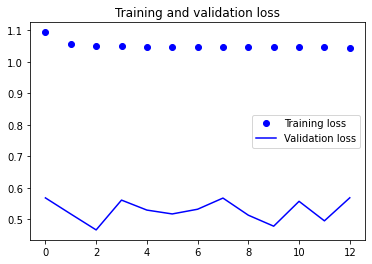

In [78]:
produce_graph(history3)


In [81]:
print_total_results(model3, X_test_small, y_test_small)

loss :  0.4668920338153839
tp :  3781.0
fp :  13228.0
tn :  45139.0
fn :  1811.0
accuracy :  0.764864981174469
precision :  0.22229407727718353
recall :  0.6761444807052612
auc :  0.8120925426483154
prc :  0.30373841524124146
